In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(8, 2))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

Input data shape: (792, 40, 40, 3)


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


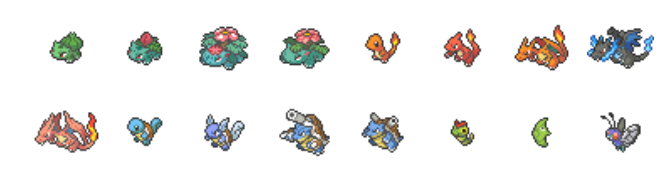

In [3]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
print 'Input data shape: {}'.format(orig_img.shape)
plotPoke(orig_img)

In [ ]:
# Parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 24
display_step = 100
examples_to_show = 8

# Network Parameters
n_input = [40, 40, 3] # Pokemon data input (img shape: 40*40*3)
n_channel1 = 16
n_channel2 = 32
n_channel2 = 64
gen_dim = 100

# tf Graph input
X = tf.placeholder(tf.float32, [None]+n_input)

In [ ]:
# Store layers weights & biases
weights = {
    # 5x5 conv, 3 inputs, 32 outputs
    'dis_h1': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel2], stddev=0.01)),
    # 5x5 conv, 32 inputs, 64 outputs
    'dis_h2': tf.Variable(tf.truncated_normal([5, 5, n_channel2, n_channel3], stddev=0.01)),
    # full connect, 64 inputs, 1 outputs
    'dis_h3': tf.Variable(tf.truncated_normal([10*10*64, 1], stddev=0.01)),
    # 5x5 conv, 16 inputs, 32 outputs
    'gen_h1': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01)),
    # 5x5 conv, 16 inputs, 32 outputs
    'gen_h2': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01)),
    # 5x5 conv, 16 inputs, 32 outputs
    'gen_h3': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01)),
    # 5x5 conv, 16 inputs, 32 outputs
    'gen_h4': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01))
}

biases = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_channel2], stddev=0.01)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'decoder_h2': tf.Variable(tf.truncated_normal([3], stddev=0.01))
}

In [ ]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

In [ ]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])
weights = {
    "w_d1" : weight_variable([5, 5, 1, 32], "w_d1"),
    "w_d2" : weight_variable([5, 5, 32, 64], "w_d2"),
    "w_d3" : weight_variable([7 * 7 * 64, 1], "w_d3"),
    
    "w_g1" : weight_variable([g_dim, 4 * 4 * 64], "w_g1"),
    "w_g2" : weight_variable([5, 5, 32, 64], "w_g2"),
    "w_g3" : weight_variable([5, 5, 16, 32], "w_g3"),
    "w_g4" : weight_variable([5, 5, 1, 16], "w_g4")
}

biases = {
    "b_d1" : bias_variable([32], "b_d1"),
    "b_d2" : bias_variable([64], "b_d2"),
    "b_d3" : bias_variable([1], "b_d3"),
    "b_g1" : bias_variable([4 * 4 * 64], "b_g1"),
    "b_g2" : bias_variable([32], "b_g2"),
    "b_g3" : bias_variable([16], "b_g3"),
    "b_g4" : bias_variable([1], "b_g4"),
}

var_d = [weights["w_d1"], weights["w_d2"], weights["w_d3"], biases["b_d1"], biases["b_d2"], biases["b_d3"]]
var_g = [weights["w_g1"], weights["w_g2"],weights["w_g3"], weights["w_g4"], biases["b_g1"], biases["b_g2"],biases["b_g3"], biases["b_g4"]]

In [ ]:
def generator(z):
    #100 x 1
    h_g1 = tf.nn.relu(tf.add(tf.matmul(z, weights["w_g1"]), biases["b_g1"]))
    #-1 x 4*4*128
    h_g1_reshape = tf.reshape(h_g1, [-1, 4, 4, 64])
    
    output_shape_g2 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_g2 = tf.nn.relu(tf.add(deconv2d(h_g1_reshape, weights["w_g2"], output_shape_g2), biases["b_g2"]))
    
    output_shape_g3 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_g3 = tf.nn.relu(tf.add(deconv2d(h_g2, weights["w_g3"], output_shape_g3), biases["b_g3"]))
    
    output_shape_g4 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_g4 = tf.nn.tanh(tf.add(deconv2d(h_g3, weights["w_g4"], output_shape_g4), biases["b_g4"]))
    
    return h_g4


def discriminator(x):
    x_reshape = tf.reshape(x, [-1, 28, 28, 1])
    # 28 x 28 x 1
    h_d1 = tf.nn.relu(tf.add(conv2d(x_reshape, weights["w_d1"]), biases["b_d1"]))
    # 14 x 14 x 32
    h_d2 = tf.nn.relu(tf.add(conv2d(h_d1, weights["w_d2"]), biases["b_d2"]))
    # 7 x 7 x 64
    h_d2_reshape = tf.reshape(h_d2, [-1, 7 * 7 * 64])
    h_d3 = tf.nn.sigmoid(tf.add(tf.matmul(h_d2_reshape, weights["w_d3"]), biases["b_d3"]))
    return h_d3